<a href="https://colab.research.google.com/github/roosvlc/DCWEB-SOBA/blob/main/BertFineTunedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Mar 31 09:20:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.__version__)
# Get the GPU device name.



2.4.1


In [ ]:
!pip install transformers
import math
import pickle
import random
import multiprocessing as mp
from transformers import BertTokenizer
from tqdm import tqdm

In [ ]:
#TOKENIZE TEXT
flatten = lambda t: [item for sublist in t for item in sublist]

tok = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 512
BATCH_SIZE = 8
print(MAX_LEN)


512


In [ ]:
#tokenize
def tokenize(x):
    return tok.encode(x)[1:-1]
print("Data: tokenized")

Data: tokenized


In [ ]:
#masking & batching
def process(_n):
    n = _n
    size = math.ceil(len(n)*0.15)
    indices = random.sample(range(len(n)), size)
    replacement_prob = [True, True, True, True, True, True, True, True, False, False]
    output = [-100]*len(n)
    for index in indices:
        output[index] = n[index]
        if random.choice(replacement_prob):
            n[index] = 103
        else:
            if random.choice([True, False]):
                n[index] = random.randint(1010, 30500)
    return (n, output)

def batcher(ins, outs):
    batchx, batchy, batchesx, batchesy, batchesmasks = [], [], [], [], []
    for i in zip(ins, outs):
        batchx.append(i[0])
        batchy.append(i[1])
        if len(batchx) == BATCH_SIZE:
            maxlen = max([len(x) for x in batchx])
            masks = [[1] * len(x) + [0] * (maxlen - len(x)) for x in batchx]
            batchx = [x + [0] * (maxlen - len(x)) for x in batchx]
            batchy = [x + [0] * (maxlen - len(x)) for x in batchy]
            batchesx.append(batchx)
            batchesy.append(batchy)
            batchesmasks.append(masks)
            batchx = []
            batchy = []
    return [batchesx, batchesy, batchesmasks]
print("Data: masked & batched")

Data: masked & batched


In [ ]:
#save to disk
real_data = list(set(flatten([x.split(".") for x in open("data_post_training20k").read().split(".")])))
print(len(real_data))
random.shuffle(real_data)

pool = mp.Pool()
tokenized = list(tqdm(pool.imap(tokenize, real_data), total=len(real_data)))

inputs = tokenized
outputs = list(tqdm(pool.imap(process, tokenized), total=len(tokenized)))
outputs.sort(key=lambda x: len(x[0]))

inputs = [[101] + x[0] + [102] for x in outputs]
outputs = [[-100] + x[1] + [-100] for x in outputs]

batched = batcher(inputs, outputs)
pickle.dump(batched, open("lblq_data.pkl", "wb"))


136103


100%|██████████| 136103/136103 [00:12<00:00, 10791.70it/s]


In [ ]:
#training
!pip install transformers
!pip install pytorch-lightning
import random
import pickle
import numpy as np
import torch
print(torch.__version__)

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import BertForMaskedLM
print("done installing and importing")

     |████████████████████████████████| 2.0MB 9.0MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
     |████████████████████████████████| 3.2MB 50.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c627629af78b667af963b9f5943fe92aa81e5fc334b8a31eecc4d828935f8306
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 839kB 8.5MB/s 
     |████████████████████████████████| 276kB 35.9MB/s 
     |████████████████████████████████| 184kB 50.6MB/s 
     |████████████████████████████████| 829kB 58.6MB/s 
     |████████████████████████████████| 112kB 44.7MB/s 
     |████████████████████████████████| 1.3MB 45.3MB/s 
     |████████████████████████████████| 143kB 55.1MB/s 
     |████████████████████████████████| 296kB 60.1MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620

1.8.1+cu101
done installing and importing


In [ ]:
class PTDataset(Dataset):
  #loading data
    def __init__(self):
        self.data = pickle.load(open("lblq_data.pkl", "rb"))
        idxs = list(range(len(self.data[0])))
        random.shuffle(idxs)
        self.data = [[x[i] for i in idxs] for x in self.data]
        print("Loaded {} rows of data".format(len(self.data[0])))
    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return [torch.tensor(x[idx]) for x in self.data]
print("check")

check


In [ ]:
class BertRestPT(pl.LightningModule):

    def __init__(self):
        super().__init__()
        #open bert model 
        self.bert = BertForMaskedLM.from_pretrained("bert-base-uncased")

#feed masks and data
    def forward(self, x):
        inp, out, mask = x
        enc = self.bert(input_ids=inp, attention_mask=mask, labels=out)
        return enc
#running training steps
    def training_step(self, batch, batch_nb):
        yhat = self(batch)
        loss = yhat.loss
        return {'loss': loss}
#uses Adam optimizer for loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-5, eps=1e-4)
print("check")
import tensorflow as tf

check


In [ ]:
#Save post-trained data
if __name__ == "__main__":
    trainer = pl.Trainer(gpus=1, distributed_backend='ddp', max_epochs=4)
    dataset = PTDataset()
    dataloader = DataLoader(dataset,batch_size = None)

    print("Loading model")
    model = BertRestPT()
    print("Loaded model")
    trainer.fit(model, dataloader)
    model.bert.save_pretrained("POST2")
print("bert model save")


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Loaded 17012 rows of data
Loading model


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: /content/lightning_logs
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1


Loaded model



  | Name | Type            | Params
-----------------------------------------
0 | bert | BertForMaskedLM | 109 M 
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.057   Total estimated model params size (MB)



bert model save


In [ ]:
#Model is post-trained on domain-specific corpus,
#Start fine-tuning bert by import the task you want to fine-tune BERT on
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load Post-Trained BERT model, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained('POST2', # Use the post-trained domain specific BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
)
model.cuda()

Some weights of the model checkpoint at POST2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at POST2 and are newly initialized: ['bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
print('Loading restaurant review data...')
file = open('/content/restData19', 'r')
review = file.read()
review = review.replace("\n\n", ' ')
reviews = review.split(",|,")
sentences = []
labels = []
i = 0 
for rev in reviews:
  sen = rev.split(",/,")
  sentences.append(sen[1])
  labels.append(int(sen[0]))
  i += 1
file = open('/content/restData2', 'r')
review1 = file.read()
review1 = review1.replace("\n\n", ' ')
reviews2 = review1.split(",|,")
i = 0 
for rev in reviews2:
  sen = rev.split(",/,")
  sentences.append(sen[1])
  labels.append(int(sen[0]))
  i += 1
print(len(sentences))

Loading restaurant review data...
100000


In [ ]:
#Call optimizer that we want to use for training
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
import time
import pprint
import pandas as pd
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('POST2', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
import torch
input_ids = []
attention_masks = []
start = time.time()
labels = torch.tensor(labels)
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation = True,
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


end = time.time()
print("Tijd: ", end-start, "s")
print(str(len(input_ids)) + ' reviews are now tokenized and have appropriate format en length.')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tijd:  242.51388359069824 s
100000 reviews are now tokenized and have appropriate format en length.


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

90,000 training samples
10,000 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

joejoe


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 1

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
print("check")

check


In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
print("check")

check


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
print("double check")

double check


In [ ]:
import random
import numpy as np
import torch

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = outputs.loss
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += outputs.loss

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  11,250.    Elapsed: 0:00:18.
  Batch    80  of  11,250.    Elapsed: 0:00:36.
  Batch   120  of  11,250.    Elapsed: 0:00:54.
  Batch   160  of  11,250.    Elapsed: 0:01:13.
  Batch   200  of  11,250.    Elapsed: 0:01:31.
  Batch   240  of  11,250.    Elapsed: 0:01:49.
  Batch   280  of  11,250.    Elapsed: 0:02:07.
  Batch   320  of  11,250.    Elapsed: 0:02:25.
  Batch   360  of  11,250.    Elapsed: 0:02:43.
  Batch   400  of  11,250.    Elapsed: 0:03:01.
  Batch   440  of  11,250.    Elapsed: 0:03:19.
  Batch   480  of  11,250.    Elapsed: 0:03:37.
  Batch   520  of  11,250.    Elapsed: 0:03:55.
  Batch   560  of  11,250.    Elapsed: 0:04:14.
  Batch   600  of  11,250.    Elapsed: 0:04:32.
  Batch   640  of  11,250.    Elapsed: 0:04:50.
  Batch   680  of  11,250.    Elapsed: 0:05:08.
  Batch   720  of  11,250.    Elapsed: 0:05:26.
  Batch   760  of  11,250.    Elapsed: 0:05:44.
  Batch   800  of  11,250.    Elapsed: 0:06:0

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.12,"tensor(0.0867, device='cuda:0')",0.98,1:24:38,0:03:04


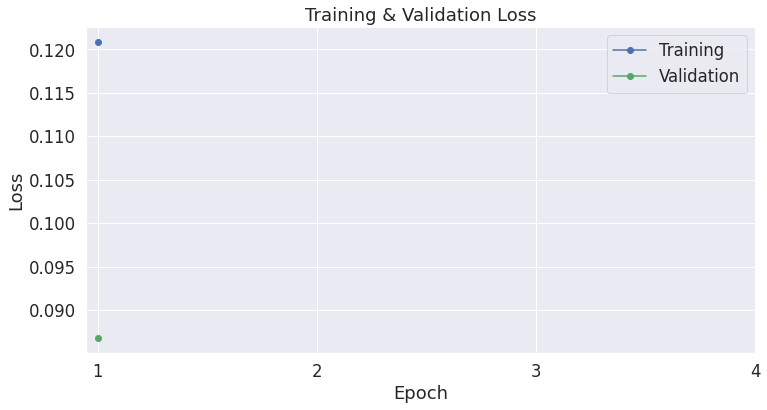

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#Save weights of created model to "output_dir"
import os

output_dir = 'FINE2'
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

model_to_save = model.module if hasattr(model,'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('FINE2/tokenizer_config.json',
 'FINE2/special_tokens_map.json',
 'FINE2/vocab.txt',
 'FINE2/added_tokens.json')